# Labsheet 6: Odometry

This labsheet investigates using the motor information available in the Webots simulation of an e-puck to implement a simple kinematic model.  This will allow for changes of pose (position and rotation) to be estimated.  Tracking the robot pose will likely become a valuable source of information for your robot.  



<hr><br><br><br><br>

# Overview: Odometry

**`Odometry`** refers to maintaining an estimate of position using sensors.  By using a last-known position and a subsequent measurement of change, it is possible to calculate an estimate of the robot position.  This technique is known as **`dead reckoning`**.

The real e-puck robot utilises `stepper motors`, and this has been simulated in Webots. `Stepper motors` increment their position by fixed angular quantity. When using `stepper motors` to effect changes of position, they can be conveniently regarded to simultaneously encode rotation.  This is achieved by counting the number of times the `stepper motor` has been commanded to increment by one angular position.  This assumption is only true when the motor has enough `torque` to effect the rotation - otherwise, the microcontroller will count rotations in software that did not happen in reality.  

 
In the previous Labsheet "Line Following", you will have developed your first `closed-loop` control system.  Hopefully, your robot was able to follow the line sufficiently well.  This would mean your robot appeared to have an intelligent autonomous behaviour.  It is important to recognise that to achieve this, your robot was utilising a `source of information` from the environment - the line.

<p align="center">
<img width="50%" src="https://github.com/paulodowd/EMATM0053_21_22/blob/main/images/3PI_InfoSource.png?raw=true">
</p>

However, despite the intelligent looking behaviour whilst line following, the robot had no idea where it was, or how far it had travelled.  In this labsheet, we will focus on generating more information for your robotic system to later utilise. In other parts of the line following challenge, relying on line following is no longer sufficient.  For instance:
- traversing the gap in the line.
- determining the end of the line.
- returning to home (start position). 

If we can utilise the rotary encoders to estimate the robot position, we can use this information to perform operations such as:
- turn to a specific angle
- move to a specific location
- maintain a straight course of travel
- estimate the distance travelled
- etc.


<hr><br><br><br><br>

# Kinematics

At this point the 3Pi+ should be reliably counting the number of encoder pulses as the wheel rotates.  You may also have attempted to translate this information into the distance travelled by each wheel respectively.  However, tracking the distance travelled by an individual wheel is insufficient to estimate the robot position in the `task environment`.

In this section, we will implement a simple kinematic model for the 3Pi+ robot.  This will integrate the contribution of both the left wheel and right wheel to estimate a resultant `pose` of the robot.  In terms of our **`task`**, it would be useful to know:
- the X position of the robot in the `task environment`.
- the Y position of the robot in the `task environment`.
- the rotation of the robot in the `task environment`.

<p align="center">
<img src="https://github.com/paulodowd/EMATM0053_21_22/blob/main/images/3PI_KinematicsOverview.png?raw=true">
</p>

As the robot travels, we will estimate it's position within a `global co-ordinate frame` annotated $X_{I}$, $Y_{I}$. In our task, it is convenient to set the origin of the `global co-ordinate frame` ($X_{I}=0$, $Y_{I}=0$) when the robot is powered on.  Therefore, where your robot is positioned when it is powered on (or reset) will become the origin of it's subsequent position estimations.

Creating a `local co-ordinate frame`, annotated as $X_{R}$, $Y_{R}$, allows us to describe the `configuration` of wheels relative to the robot centre at point $p$.  For our robot, the chassis holds two wheels in a fixed relation (e.g., they are fixed on either side of the robot, and cannot be repositioned).  We assume:
- the robot also has wheels of the same size, radius $r$.  
- the wheels are configured at a distance $l$ and rotated +/- 90&deg; ($\pi/2$) respectively from $X_{R}$. This aligns the direction of travel of both wheels with $X_{R}$.  


We then address the central question of how the rotation velocity of the left and right wheels, $\phi_{l}$ and $\phi_{r}$, will displace the robot within the local frame:

> $\dot{X_{R}} = \frac{r\phi_{l}}{2} + \frac{r\phi_{r}}{2} $
<br> the contribution along $X_{R}$, which we understood as each wheel contributing to half the forward motion of the robot at point $p$. 

> $\dot{Y_{R}} = 0$
<br> the contribution along $Y_{R}$, which we understood as being zero contribution because the wheels are aligned to $X_{R}$ and unable to slide. 

> $\dot{\theta_{R}} = \frac{r\phi_{l}}{2 l} - \frac{r\phi_{r}}{2 l}$
<br>the contribution of rotation, which we understood to describe the counter-active motion of each wheel, if any, proportional to their distance of separation $2l$.  

The above contributions (note, the small dot above the letter indicates they are a contribution) are in the local co-ordinate frame.  Therefore, each component will have a magnitude relative to the local origin.  To utilise these as a displacement in the global co-ordinate frame, they require rotating and translating with respect to the prior pose of the robot.  Rotation is achieved via an `orthogonal rotation matrix` using $\theta_{I}$.  Because $\dot{Y_{R}}$ is always 0 in our simple model, the matrix multiplication simplifies to the following:

<p align="center">
<img width="50%" src="https://github.com/paulodowd/EMATM0053_21_22/blob/main/images/kinematic_update.png?raw=true">
</p>

Including the translation, our update calculation at each time step $t$ is therefore:
<br>
<p align="center">
$X_{I}^{\;t+1} = X_{I}^{\;t} + ( \;\dot{X_{R}} \; cos \; \theta_{I}^{\;t}\; )$
</p>

<p align="center">
$Y_{I}^{\;t+1} = Y_{I}^{\;t} + (\;\dot{X_{R}}\; cos \;\theta_{I}^{\;t}\; )$ 
</p>

<p align="center">
$\theta_{I}^{\;t+1} = \theta_{I}^{\;t} + \dot{\theta_{R}}$
</p>






<hr><br><br><br><br>

## Exercise 2: Implement Kinematics

1. Review and update the `class` within `kinematics.h` source file of the 3Pi+ Arduino template available via Github (<a href="https://github.com/paulodowd/EMATM0053_21_22/tree/main/3PI_CodeStub">Github Page</a>, <a href="https://github.com/paulodowd/EMATM0053_21_22/raw/main/3PI_CodeStub/Labsheet_X.zip">Download Link for Zip file</a>), or create your own.  In this first exercise, aim to get a reasonable but not perfect level of performance.  Your main goal should be to ensure there are no bugs in your code.
  - You may wish to implement the kinematics within `loop()` until you feel confident it is working, before working within the `class` construct.
  - For estimating position, it is not necessary to attempt to update position with every change to the encoder count.  Instead, decide a reasonable and regular time interval to perform your kinematic update.  
  - Your code will need to know the change in encoder counts since the last time the kinematics was updated.  Create variables to store and update this information.  
    - Start your kinematic update function by ensuring you can register and update a change of encoder counts.
    - Remember to pay attention to variable `data types` and potential bugs.
  - In a previous exercise, you will have calculated some useful information:
    - the total number of encoder counts per revolution.
    - the mm of travel per encoder count.
  - Use either the measurements of the 3Pi+ provided in the <a href="https://www.pololu.com/docs/0J83">documentation</a>, or take your own measurements of $l$ and $r$.  
  - Start by implementing only the $X$ contribution:
    - **Validate:** Moving the robot backwards and forwards (no rotation), check that the values reported for a full rotation of both left and right wheels together appears correct.
    - Moving the robot slowly by hand (no battery power) will likely make this easier.
    - Select a distance, such as 100mm, to validate your kinematics.
  - Imlpement the $\theta$ contribution:
    - When working on $\theta$, test your robot without any translation motion (forwards/backwards).
    - **Validate:** place your robot on a surface with a known angle marked out.  This could be 90&deg;, or a small chart of angles (plenty are available via a <a href="https://www.google.com/search?q=radians+angles&tbm=isch&ved=2ahUKEwjopoDK5ZfzAhUP_RoKHcq5BVYQ2-cCegQIABAA&oq=radians+angles&gs_lcp=CgNpbWcQAzIFCAAQgAQyBQgAEIAEMgYIABAIEB4yBggAEAgQHjIGCAAQCBAeMgYIABAIEB4yBggAEAgQHjIGCAAQCBAeMgYIABAIEB4yBggAEAgQHjoHCCMQ7wMQJzoECAAQQzoGCAAQBRAeUKbLBFiJ1gRg3NYEaABwAHgAgAE6iAGVA5IBATiYAQCgAQGqAQtnd3Mtd2l6LWltZ8ABAQ&sclient=img&ei=_NxNYei4L4_6a8rzlrAF&bih=937&biw=1920&rlz=1C1GCEB_enGB928GB928">Google Image search</a>).  
    - Move your robot by hand to check that it is calculating a good estimation of rotation.
    - **Validate:** Does $\theta$ increment and decrement clockwise and anti-clockwise as you would expect?  



<hr><br><br><br><br>

## Exercise 3: Improve Odometry

1. Look to improve your odometry.  It is recommended that you collect some data and practice graphing using a `boxplot` to evaluate performance.  A `boxplot` example has been provided below.

- Write some motor operation code so that your robot will drive forwards until it reaches a set distance.
  - For this exercise, do not use time to travel a distance.  Instead, write code to control motors via your global co-ordinate $X$ value.
  - **Evaluate:** Take measurments of your robot's stopping distance, both in terms of the internal measurement (odometry) and the external reality (`ground truth`).
    - Does your robot `overshoot` (stop late), or `undershoot` (stop early)?  
    - How is this visible on your boxplot?
    - Is this a problem with your motor control, or an error in kinematics?
    - In the procedure you have adopted to measure distance, how might you improve the precision and accuracy of your measurements, or your capability to record error?
  - **Hypothesise:** Given the form of the update equations, which parameter is most likely to effect the performance of the $X_{R}$ contribution?  
    - Adjust likely parameters to improve the performance, and repeat your evaluation.
    - Why might parameters deviate from the documented values?
  - **Note:** At this stage in the labsheets, your robot may still accrue some rotation during this forward/backward movement.  We will investigate how to control for this in the next labsheet covering PID.  

- Write some motor operation code so that your robot will rotate on the spot to a specific angle.
  - For this exercise, do not use time to perform a rotation.  Instead, write code to control motors via your global co-ordinate $\theta$ value.
  - **Evaluate:** Perform similar evaluations as the above.  Take a number of measurements to `characterise` the performance of your robot. 
    - In the procedure you have adopted to measure distance, how might you improve the precision and accuracy of your measurements, or your capability to record error?
  - **Hypothesise:** Make a similar hypothesis on which parameter most effects the $\theta$ contribution.  Explore parameters to see if you can improve the error when your robot rotates on the spot.

- Consider the observations you have made of translation and rotation movement for your robot.
 - **Hypothesise:** Which of these generates the more significant error in your odometry.  Discuss:
  - possible causes within your robotic system, across environment, hardware, software and task.
  - a rationale for why rotation or translation has the greater impact.

[Text(0, 0.5, 'Rotation Error (degrees)'),
 Text(0.5, 0, 'Implementation'),
 Text(0.5, 1.0, 'Fictional Results')]

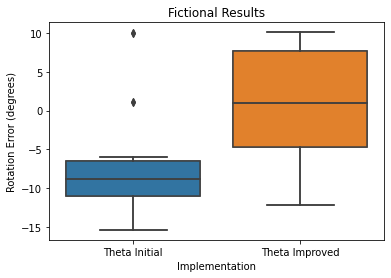

In [ ]:
#
# An example of using Python, Seaborn and
# Pandas to plot data into a Boxplot. 

# We will use a library called Seaborn to 
# make our box plot for us, so we import it.
import seaborn as sns


# To graph more than one dataset is a little 
# complicated.  We need to format the
# data into 'dataframes'.  We use the pandas
# library to do this for us.  Import pandas:
import pandas as pd

# Add your measurements into the arrays
# like the following.  
# Here, these are distance between the
# 3Pi+ center and the line center.
x_error_initial = [-9.1, -12.4, -8.6, -10.3, -15.4, -11.2, 10.0, -6.0, -8.1, 1.1]  
x_error_improved = [-12.2, 10.1, 8.1, -8.2, 0.2, 8.5, -6.4, 6.2, 1.1, 0.8]

th_error_initial = [-9.1, -12.4, -8.6, -10.3, -15.4, -11.2, 10.0, -6.0, -8.1, 1.1]  
th_error_improved = [-12.2, 10.1, 8.1, -8.2, 0.2, 8.5, -6.4, 6.2, 1.1, 0.8]

# You can make further arrays, following the
# pattern:
# pwm_60 = [ , , , ]

# We use the .DataFrame() function to apply a 
# label to each array of results
x_initial_dataframe = pd.DataFrame({'X Initial':x_error_initial})
x_improved_dataframe = pd.DataFrame({'X Improved':x_error_improved})

th_initial_dataframe = pd.DataFrame({'Theta Initial':th_error_initial})
th_improved_dataframe = pd.DataFrame({'Theta Improved':th_error_improved})


# We then add the two dataframes together.
x_combined = pd.concat([ x_initial_dataframe, x_improved_dataframe], axis=0)

th_combined = pd.concat([ th_initial_dataframe, th_improved_dataframe], axis=0)

# We can now plot both datasets at the same time.
plot_x_error = sns.boxplot(data=x_combined)
plot_x_error.set(xlabel ="Implementation", ylabel = "Travel Error (mm)", title ='Fictional Results')

#plot_th_error = sns.boxplot(data=th_combined)
#plot_th_error.set(xlabel ="Implementation", ylabel = "Rotation Error (degrees)", title ='Fictional Results')

<hr><br><br><br><br>

## Exercise 4: Improve Kinematics

**For the line following challenge, the simple kinematic model provided is sufficient to enable your robot to travel back to where it started with reasonable performance.  The exercises in this section can be considered optional or suitable for further work.**  

In the simple model detailed in this labsheet, we have worked with the assumption that the robot will move or rotate, exclusively (either one or the other). As such, our model translates by some amount $X_{R}$ and then rotates this translation motion by some $\theta_{R}$.  These operations are accounted for by the following motor activations:

- when left and right motors have equal non-zero velocity and in the same direction, $v_{l} = v_{r} \ne 0$, the robot will move forwards or backwards in a straight line.
- when the left and right motors have equal non-zero and inversed velocity, $v_{l} = -v_{r} \ne 0$, the robot will rotate on the spot.

This presents the exceptional case when the left and right motor are of different velocity, including cases where one my be 0.  Under these conditions, the robot will move on an arc. 

In our simplified model, we assume that travel on an arc can be sufficiently approximated by the integrating the rotation of the straight line segments generated by $X_{R}$.  

When the wheels have differing velocity, the point of rotation for the movement moves away from point $p$.  This new point of rotation is referred to as the `instantaneous centre of rotation` (ICR).  The more similar the wheels speeds, the further the ICR moves from point $p$.


1. As a matter of interest:
  - **Hypothesise:** If the ICR moves away from point $p$, and so defines an arc of travel for the robot, will the simplified model under-estimate or over-estimate the resultant position in comparison?
2. Implement ICR and the kinematic update routine. 
  - If you need help with this exercise, discuss the matter with the teaching staff. They will help you to decide if you should insatead continue further with labsheets and come back to this later.
  - When working on this implementation, be aware of divide-by-zero errors.
  - Any gain in performance from this implementation is likely to be more pronounced and visible when you address the full line following challenge, especially the return to home objective.  Therefore, you may need to return to this exercise later.  


